###  UPDATE 1
#### · Replace test data with values from structure subset
#### · Replace conditional entropy with posterior posibility
#### · Simulation with data suggested (Still could not figure with feature importance)
#### · Impute empty leaves value
#### · Roughly compare with permutation based methods


###  UPDATE 2
#### · Replace test data with honest subset
#### · Replace np.abs with something else(undecided)

### Update 3
#### · Replace variance with classification error

In [1]:
import sys
import time
import numpy as np
import math
import pandas as pd
from sklearn.utils.validation import check_X_y
from honest_forests.estimators import HonestTreeClassifier
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.validation import check_X_y
from sklearn.utils.multiclass import check_classification_targets
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import scipy.stats as stats

In [2]:
##Simulation Data 
#https://nbviewer.org/github/rflperry/math_tutorials/blob/master/tutorials/StatPatternRecognition/Trunk.ipynb

def simulate(n, d):
    n1 = np.random.binomial(n, 0.5)
    n2 = n - n1
    mu = 1 / np.sqrt(np.arange(1, d+1))

    X = np.vstack((
        np.random.normal(mu, 1, (n1, d)),
        np.random.normal(-mu, 1,  (n2, d))
    ))
    
    return X, np.asarray([1]*n1 + [0]*n2)


In [3]:
def Posterior_After(X,v,n_sample):
    
    #Duplicate the sigle sample test
    X_testsample_duplicated = np.tile(X,(n_sample,1))
    
    ### Replace test data with values from structure subset   
    X_variable = np.random.choice(X_structure[:,v],size = n_sample, replace=True)
    
    X_testsample_duplicated[:,v] = X_variable
    X_testsample_duplicated = X_testsample_duplicated.astype(np.float32)
    
    #Obtain the possible leaves with ignoring variable v
    leaves_indicies = np.unique(clf.tree_.apply(X_testsample_duplicated)) 
    value_leaves = np.sum(clf.tree_.value[leaves_indicies], axis=0)
    
    #Calculate the posterior probability for sample x
    
    posterior_proba = value_leaves/np.sum(value_leaves) 
    
    
    return value_leaves,posterior_proba
    
    

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


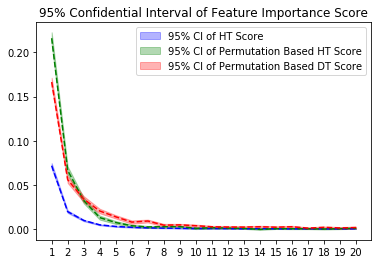

In [4]:
d = 20
N = 100
score_ht = np.zeros((N,d))
score_htp = np.zeros((N,d))
score_dtp = np.zeros((N,d))

for num in range(0,N):
    X_train, y_train = simulate(n=10000, d=d)
    X_test, y_test = simulate(n=200, d=d)

    #Train an Honest Tree
    ###We find that the honest tree nust be full trained？
    ###there will be difference for the rank of feature imporatnces  
    t_ht = time.time()
    clf = HonestTreeClassifier(random_state=15,honest_fraction = 0.8)
    clf = clf.fit(X_train, y_train)

    X_structure = X_train[clf.structure_indices_]
    X_honest = X_train[clf.honest_indices_]
    y_honest  = y_train[clf.honest_indices_]
    #np.random.choice(X_structure[:,1],size = 100, replace=True)
    #pd.DataFrame(X_structure[:,1]).sample(n = 100, replace=True)
    #print(y_honest)


    leaves_indicies_before = clf.tree_.apply(X_honest.astype(np.float32))
    value_leaves_before = clf.tree_.value[leaves_indicies_before]
    classification_before = np.zeros(X_honest.shape[0])
    #error_before = np.zeros((X_honest.shape[0],1))

    posterior_proba_before = np.zeros((X_honest.shape[0],2))##n_classes
    value_leaves = np.zeros((X_honest.shape[0],2))
    posterior_proba = np.zeros((X_honest.shape[0],2))
    classification_after = np.zeros(X_honest.shape[0])
    difference_clf = np.zeros(X_honest.shape[0])
    #error_after = np.zeros((X_honest.shape[0],1))

    mean_diff = []


    for k in range(0,X_honest.shape[1]):
        for i in range(0,X_honest.shape[0]):

            ##Compute posterior probability before merging
            posterior_proba_before[i,:] = value_leaves_before[i,:]/np.sum(value_leaves_before[i,:])




            ##Compute posterior probability after merging
            value_leaves[i,:],posterior_proba[i,:] = Posterior_After(X_honest[i,:],k,50)






        #Compute the difference of posterior possibility for just one class

        ## Get the classification_before result
        classification_before[posterior_proba_before[:,0]>= 0.5] = 0
        classification_before[posterior_proba_before[:,0]< 0.5] = 1
        #print(classification_before)

        ## Get the classification_after result
        classification_after[posterior_proba[:,0]>= 0.5] = 0
        classification_after[posterior_proba[:,0]< 0.5] = 1


        #Calculate classification error before 
        error_before = np.mean(np.abs(y_honest - classification_before))

        #Calculate classification error after merging leaves
        error_after = np.mean(np.abs(y_honest - classification_after))

        #Calculate the difference of classification error
        difference_clf = error_after - error_before

        mean_diff = np.append(mean_diff,difference_clf)
    
    #Save HT socre
    score_ht[num,:] = mean_diff
    
    
    #Calculter Permutation Based HT socre
    r_ht = permutation_importance(clf, X_test, y_test,n_repeats=5,random_state=0)
    score_htp[num,:] = r_ht.importances_mean
    
    #Calculter Permutation Based Decision Tree(DT) socre
    clf2 = DecisionTreeClassifier(random_state=15)
    clf2 = clf2.fit(X_train, y_train)

    r_dt = permutation_importance(clf2, X_test, y_test,n_repeats=5,random_state=0)
    score_dtp[num,:] = r_dt.importances_mean

#Calculate 95% CI of HT socre around 50 times iterations
score_ht_mean = np.mean(score_ht,axis = 0)
ci_ht_low,ci_ht_up = stats.t.interval(0.95, N-1, loc=np.mean(score_ht,axis = 0), scale=stats.sem(score_ht,axis = 0))
plt.plot(np.arange(1,d+1,1),score_ht_mean,'b--')
plt.fill_between(np.arange(1,d+1,1),ci_ht_low,ci_ht_up,alpha = 0.3,color = 'blue',label = '95% CI of HT Score')

#Calculate 95% CI of Permutation Based HT socre around 50 times iterations
score_htp_mean = np.mean(score_htp,axis = 0)
ci_htp_low,ci_htp_up = stats.t.interval(0.95, N-1, loc=np.mean(score_htp,axis = 0), scale=stats.sem(score_htp,axis = 0))
plt.plot(np.arange(1,d+1,1),score_htp_mean,'g--')
plt.fill_between(np.arange(1,d+1,1),ci_htp_low,ci_htp_up,alpha = 0.3,color ='green',label = '95% CI of Permutation Based HT Score')

#Calculate 95% CI of Permutation Based DT socre around 50 times iterations
score_dtp_mean = np.mean(score_dtp,axis = 0)
ci_dtp_low,ci_dtp_up = stats.t.interval(0.95, N-1, loc=np.mean(score_dtp,axis = 0), scale=stats.sem(score_dtp,axis = 0))
plt.plot(np.arange(1,d+1,1),score_dtp_mean,'r--')
plt.fill_between(np.arange(1,d+1,1),ci_dtp_low,ci_dtp_up,alpha = 0.3,color ='red',label = '95% CI of Permutation Based DT Score')

plt.xticks(np.arange(1, d+1, 1))
plt.legend()
plt.title('95% Confidential Interval of Feature Importance Score')
plt.savefig('95% Confidential Interval of Feature Importance Score')
plt.show()

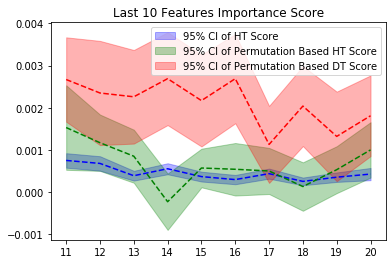

In [5]:
plt.plot(np.arange(11,d+1,1),score_ht_mean[10:],'b--')
plt.fill_between(np.arange(11,d+1,1),ci_ht_low[10:],ci_ht_up[10:],alpha = 0.3,color = 'blue',label = '95% CI of HT Score')

plt.plot(np.arange(11,d+1,1),score_htp_mean[10:],'g--')
plt.fill_between(np.arange(11,d+1,1),ci_htp_low[10:],ci_htp_up[10:],alpha = 0.3,color ='green',label = '95% CI of Permutation Based HT Score')

plt.plot(np.arange(11,d+1,1),score_dtp_mean[10:],'r--')
plt.fill_between(np.arange(11,d+1,1),ci_dtp_low[10:],ci_dtp_up[10:],alpha = 0.3,color ='red',label = '95% CI of Permutation Based DT Score')

plt.xticks(np.arange(11, d+1, 1))
plt.legend()
plt.title ("Last 10 Features Importance Score")
plt.savefig("Last 10 Features Importance Score")
plt.show()